In [1]:
import numpy as np
import os
import random
from pathlib import Path
import tarfile
import matplotlib.pyplot as plt

from nilearn import plotting, image, datasets
from nilearn.maskers import NiftiSpheresMasker
from nilearn.connectome import ConnectivityMeasure
import nibabel as nib

from sklearn.covariance import GraphicalLassoCV

/Users/vickyli/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
folder = 'HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2'
all_files = [f for f in os.listdir(folder) if f.endswith('.txt')]

# len(all_files)

## Calculate Average Correlation Matrix Across (1003) Subjects

average over subject

In [3]:
all_correlation_matrices = []

# calculate the correlation matrix for the each subject 
for filename in all_files:
    file_path = os.path.join(folder, filename)
    subject_data = np.loadtxt(file_path)
    correlation_matrix = np.corrcoef(subject_data.T)  # Shape: (100, 100)
    all_correlation_matrices.append(correlation_matrix)

# convert to a NumPy array for averaging
all_correlation_matrices = np.array(all_correlation_matrices)


In [4]:
# there is one correlation matrix for each subject, pairwise with 100 components.
all_correlation_matrices.shape

(1003, 100, 100)

#### average correlation for specific pairs of brain regions across all subjects

In [15]:
average_correlation_matrix = np.mean(all_correlation_matrices, axis=0)
average_correlation_matrix.shape

(100, 100)

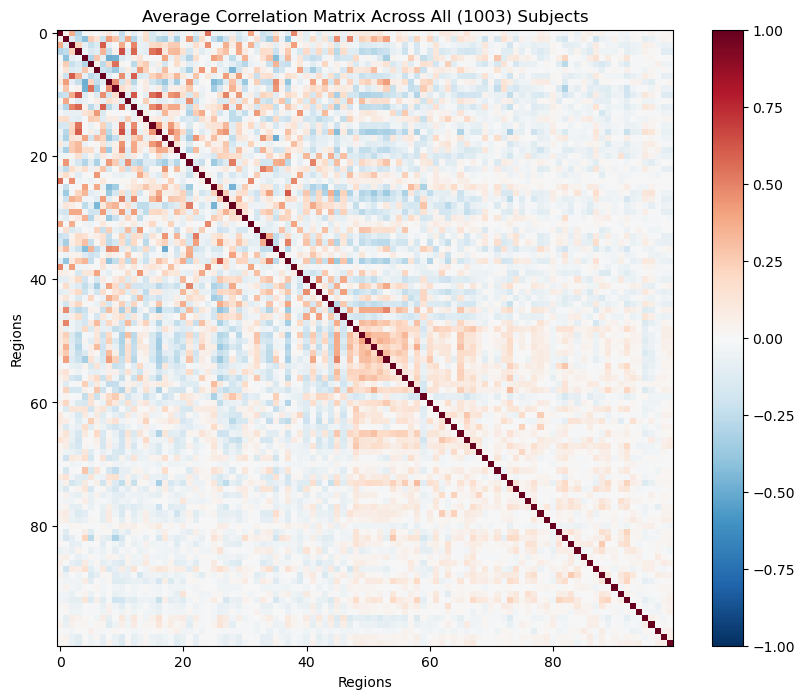

In [6]:
plt.figure(figsize=(10, 8))
plt.imshow(average_correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Average Correlation Matrix Across All (1003) Subjects')
plt.xlabel('Regions')
plt.ylabel('Regions')
plt.show()


## Calculate Average Correlation Matrix Across Time Segments (Each Run or Each 5 Minute)

average over time

**Four complete rfMRI runs (4800 total timepoints)**

**Each run lasts 15 minutes**

**4800 time points makes up 1 hours of scan.**

1. Analyzing the average correlation matrix for each run (15 minutes)

In [7]:
total_timepoints = 4800
timepoints_per_run = 1200  # 1200 time points per run (15 minutes each)

correlation_matrices_each_run = {}  # Store correlation matrices by run

for filename in all_files:
    file_path = os.path.join(folder, filename)
    subject_data = np.loadtxt(file_path)

    # extract the correlation matrix for each subject and for each run
    run_corr_matrices = []
    for run in range(4):
        run_data = subject_data[run * timepoints_per_run: (run + 1) * timepoints_per_run, :]
        run_corr_matrix = np.corrcoef(run_data.T)
        run_corr_matrices.append(run_corr_matrix)

    correlation_matrices_each_run[filename] = run_corr_matrices # for each subject

In [8]:
# for each subject, there are 4 correlation matrices, one for each run. 
len(correlation_matrices_each_run),len(correlation_matrices_each_run['237334.txt'])

(1003, 4)

In [9]:
# shape of each correlation matrix is 100*100
correlation_matrices_each_run['237334.txt'][0].shape

(100, 100)

In [10]:
np.mean(correlation_matrices_each_run['237334.txt'], axis=0)

array([[ 1.        ,  0.09563266,  0.16217779, ..., -0.04890383,
         0.08946534,  0.12941787],
       [ 0.09563266,  1.        , -0.10128666, ..., -0.06986808,
         0.03858683, -0.00467704],
       [ 0.16217779, -0.10128666,  1.        , ..., -0.05782749,
        -0.01277867,  0.00390437],
       ...,
       [-0.04890383, -0.06986808, -0.05782749, ...,  1.        ,
         0.04322593,  0.04784764],
       [ 0.08946534,  0.03858683, -0.01277867, ...,  0.04322593,
         1.        ,  0.04949362],
       [ 0.12941787, -0.00467704,  0.00390437, ...,  0.04784764,
         0.04949362,  1.        ]])

In [11]:
all_subject_run_avg_matrices = []

# calculate the average correlation matrix for each subject across runs
for filename in correlation_matrices_each_run.keys():
    subject_run_avg = np.mean(correlation_matrices_each_run[filename], axis=0)
    all_subject_run_avg_matrices.append(subject_run_avg)

group_run_avg_matrix = np.mean(all_subject_run_avg_matrices, axis=0)
group_run_avg_matrix

array([[ 1.        ,  0.03746642,  0.36589967, ..., -0.00320988,
         0.02117171,  0.02963068],
       [ 0.03746642,  1.        , -0.12051823, ..., -0.02201362,
         0.03646411,  0.02226646],
       [ 0.36589967, -0.12051823,  1.        , ..., -0.02381649,
        -0.06168555, -0.05744385],
       ...,
       [-0.00320988, -0.02201362, -0.02381649, ...,  1.        ,
         0.04303795,  0.05417848],
       [ 0.02117171,  0.03646411, -0.06168555, ...,  0.04303795,
         1.        ,  0.06800776],
       [ 0.02963068,  0.02226646, -0.05744385, ...,  0.05417848,
         0.06800776,  1.        ]])

2. Analyzing the average correlation matrix based on time (5-minute interval)

In [12]:
total_timepoints = 4800
timepoints_per_run = 120
timepoints_per_5min_segment = timepoints_per_run // 3  # 400 time points for each 5-minute segment

segment_based_correlation_matrices = {} 

for filename in all_files:
    file_path = os.path.join(folder, filename)
    subject_data = np.loadtxt(file_path)

    segment_corr_matrices = []
    for run in range(4): # 3 segments per run, 4 runs, 12 total
        for segment in range(3):
            # Extract data for the current 5-minute segment within the run
            start_idx = run * timepoints_per_run + segment * timepoints_per_5min_segment
            end_idx = start_idx + timepoints_per_5min_segment
            segment_data = subject_data[start_idx:end_idx, :]

            # calculate and store the correlation matrix for the segment
            segment_corr_matrix = np.corrcoef(segment_data.T)
            segment_corr_matrices.append(segment_corr_matrix)

    # for each subject
    segment_based_correlation_matrices[filename] = segment_corr_matrices

In [13]:
all_subject_segment_avg_matrices = []
for filename in segment_based_correlation_matrices.keys():
    subject_segment_avg = np.mean(segment_based_correlation_matrices[filename], axis=0)  # Shape: (100, 100)
    all_subject_segment_avg_matrices.append(subject_segment_avg)

group_segment_avg_matrix = np.mean(all_subject_segment_avg_matrices, axis=0)

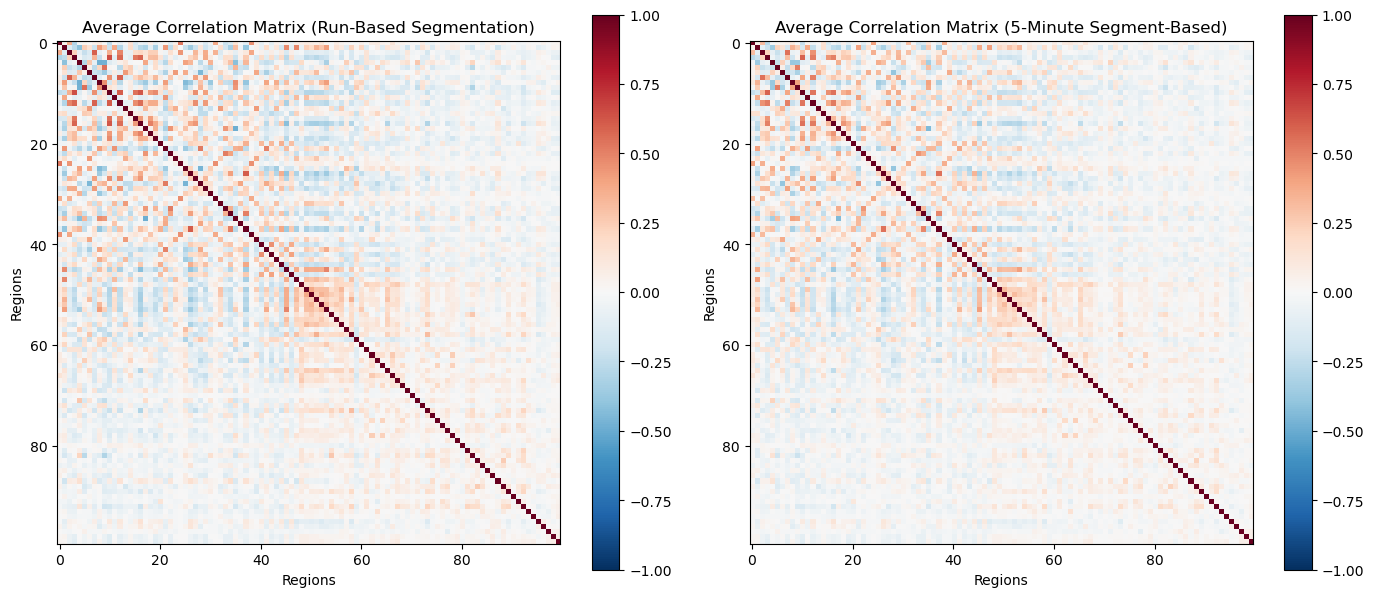

In [14]:
# Step 3: Plot the Group-Level Average Correlation Matrix for Each Method
plt.figure(figsize=(14, 6))

# for run-based correlation matrix
plt.subplot(1, 2, 1)
plt.imshow(group_run_avg_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Average Correlation Matrix (Run-Based Segmentation)')
plt.xlabel('Regions')
plt.ylabel('Regions')

# for time-based (5-min) correlation matrix
plt.subplot(1, 2, 2)
plt.imshow(group_segment_avg_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Average Correlation Matrix (5-Minute Segment-Based)')
plt.xlabel('Regions')
plt.ylabel('Regions')

plt.tight_layout()
plt.show()

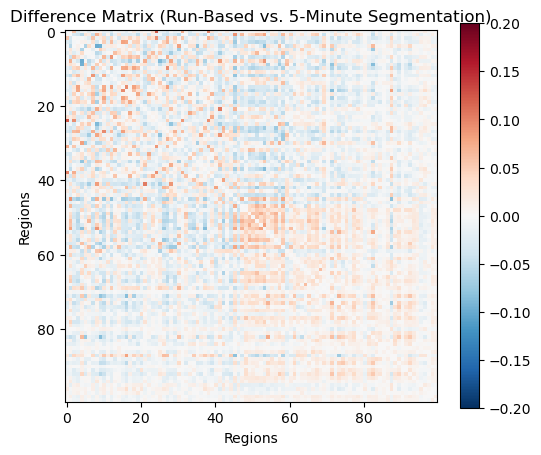

In [20]:
difference_matrix = group_run_avg_matrix - group_segment_avg_matrix

# Plotting the Difference Matrix
plt.figure(figsize=(6, 5))
plt.imshow(difference_matrix, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
plt.colorbar()
plt.title('Difference Matrix (Run-Based vs. 5-Minute Segmentation)')
plt.xlabel('Regions')
plt.ylabel('Regions')
plt.show()

In [22]:
# Get difference for correlations of the top 10 differing region pairs
num_top_diffs = 20
abs_diff = np.abs(difference_matrix)
top_diff_indices = np.dstack(np.unravel_index(np.argsort(abs_diff.ravel())[-num_top_diffs:], difference_matrix.shape))[0]

for idx in top_diff_indices:
    region1, region2 = idx[0], idx[1]
    run_corr = group_run_avg_matrix[region1, region2]
    segment_corr = group_segment_avg_matrix[region1, region2]
    diff = difference_matrix[region1, region2]
    
    print(f"Regions ({region1}, {region2}): Run-Based = {run_corr:.3f}, Segment-Based = {segment_corr:.3f}, Difference = {diff:.3f}")

Regions (45, 1): Run-Based = 0.473, Segment-Based = 0.382, Difference = 0.090
Regions (1, 45): Run-Based = 0.473, Segment-Based = 0.382, Difference = 0.090
Regions (24, 38): Run-Based = 0.458, Segment-Based = 0.366, Difference = 0.092
Regions (38, 24): Run-Based = 0.458, Segment-Based = 0.366, Difference = 0.092
Regions (24, 2): Run-Based = 0.445, Segment-Based = 0.352, Difference = 0.093
Regions (2, 24): Run-Based = 0.445, Segment-Based = 0.352, Difference = 0.093
Regions (27, 10): Run-Based = 0.463, Segment-Based = 0.369, Difference = 0.094
Regions (10, 27): Run-Based = 0.463, Segment-Based = 0.369, Difference = 0.094
Regions (16, 15): Run-Based = 0.426, Segment-Based = 0.331, Difference = 0.094
Regions (15, 16): Run-Based = 0.426, Segment-Based = 0.331, Difference = 0.094
Regions (4, 9): Run-Based = -0.470, Segment-Based = -0.374, Difference = -0.096
Regions (9, 4): Run-Based = -0.470, Segment-Based = -0.374, Difference = -0.096
Regions (38, 0): Run-Based = 0.453, Segment-Based = 0.